In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow.keras
import tensorflow as tf
import seaborn as sns
from functools import partial
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense,Flatten
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D,MaxPool2D,Activation
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as Kfrom tensorflow.keras.layers import Dense,Add, Dropout, Resizing,Rescaling,InputLayer,Flatten,LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Model
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator





In [ ]:
learning_rate = 0.001
class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 100
image_size = 72  


In [ ]:
train_data='/content/Brain Tumor Segmentation Dataset/image'


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)


Found 4237 files belonging to 4 classes.
Using 3390 files for training.
Found 4237 files belonging to 4 classes.
Using 847 files for validation.


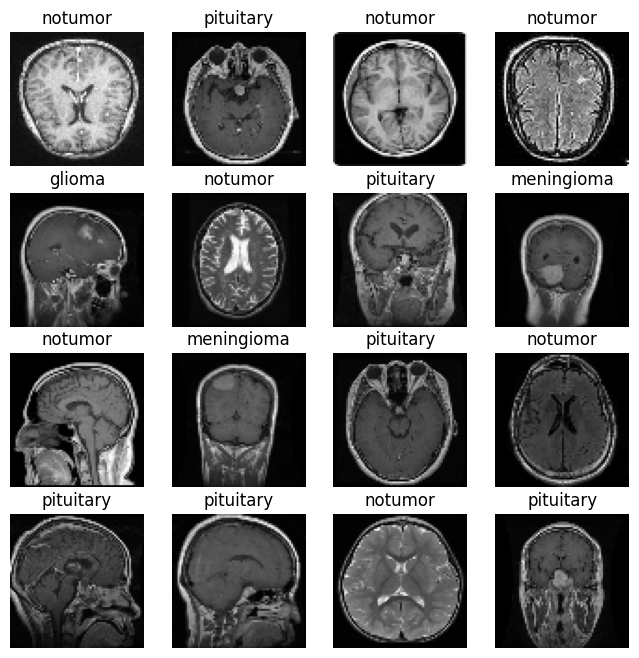

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()


In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,rotation_range=30,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,validation_split = 0.20
 )

valid_datagen = image.ImageDataGenerator(rescale=1./255,validation_split = 0.20)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size = (180,180),
    batch_size = 32,subset = 'training',
     class_mode = 'categorical')

Found 3392 images belonging to 4 classes.


In [ ]:
validation_generator = valid_datagen.flow_from_directory(
    train_data,
    target_size = (180,180),
    batch_size = 32,subset = 'validation',
    class_mode = 'categorical')

test_datagen  = image.ImageDataGenerator(rescale = 1./255)
test_dataset  = test_datagen.flow_from_directory(train_data,
                                                 target_size = (180,180),
                                                 class_mode = 'categorical',
                                                 batch_size = 32,
                                                 shuffle=False)

Found 845 images belonging to 4 classes.


In [ ]:
input_tensor = Input(shape=(180,180, 3))
base_model = tensorflow.keras.applications.InceptionResNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

219055592/219055592 [==============================] - 6s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs = 20,
                        verbose = 1)
model.save("outmodel")

Epoch 1/20
106/106 [==============================] - 776s 7s/step - loss: 0.6372 - accuracy: 0.8013 - val_loss: 1.0132 - val_accuracy: 0.7172
Epoch 2/20
106/106 [==============================] - 776s 7s/step - loss: 0.3090 - accuracy: 0.8912 - val_loss: 0.6263 - val_accuracy: 0.8083
Epoch 3/20
106/106 [==============================] - 771s 7s/step - loss: 0.2637 - accuracy: 0.9021 - val_loss: 0.5272 - val_accuracy: 0.8237
Epoch 4/20
106/106 [==============================] - 762s 7s/step - loss: 0.2207 - accuracy: 0.9210 - val_loss: 0.5850 - val_accuracy: 0.8213
Epoch 5/20
106/106 [==============================] - 756s 7s/step - loss: 0.1969 - accuracy: 0.9245 - val_loss: 0.6314 - val_accuracy: 0.8237
Epoch 6/20
106/106 [==============================] - 760s 7s/step - loss: 0.1822 - accuracy: 0.9325 - val_loss: 0.5083 - val_accuracy: 0.8521
Epoch 7/20
106/106 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9422

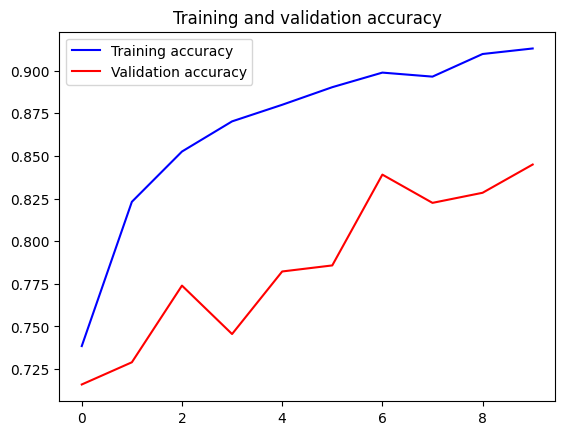

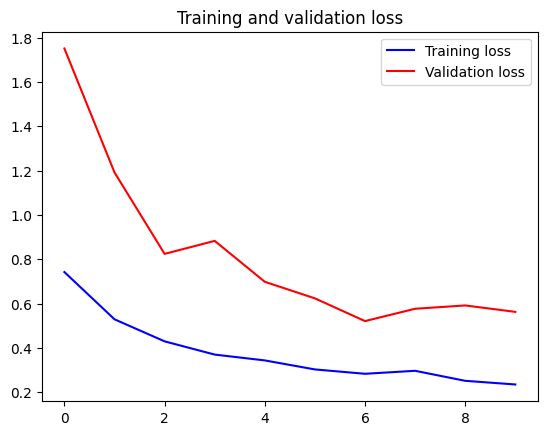

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

<Axes: >

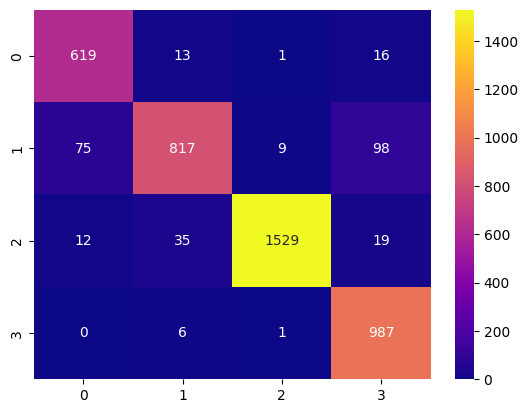

In [ ]:
y_true=[]
pred=[]

y_true = test_dataset.classes
pred = np.argmax(model.predict(test_dataset), axis=1)
from sklearn import metrics
cm=metrics.confusion_matrix(y_true, pred)
import seaborn as sns
sns.heatmap(cm,fmt="d",annot=True)